# _evosim_ EnsembleSimulator mode example: cancer patient cohort
### In this example, we will use the Simulator mode to generate a patient population by evolving a set of tumors up to detectable size from a single cell under a variety of simulation parameters drawn from distributions in order to simulate inter-patient tumor heterogeneity. We will then use the EnsembleSimulator mode to set up a standard therapeutic plan (resection followed by adjuvant therapy and subsequent monitoring) and perform retrospective survival analysis of the data.

Note: No pharmacokinetic modeling is used here, so that drug concentrations are assumed to reach all cells at their stated concentrations. Pharmacokinetic modeling can be implemented into the drug response if desired.
Note: Two of the cells take between 30 seconds and a minute to execute.

In [1]:
# these are not necessary for evosim functionalities, but we will use them elsewhere in the 
#tutorial to visualize some of the results
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from lifelines import KaplanMeierFitter,CoxPHFitter
import seaborn as sns
from scipy import stats
import random

In [2]:
#Included here for reproducibility
np.random.seed(7)
random.seed(2)

In [3]:
# import the Simulator and EnsembleSimulator modules
from evosim import Simulator,EnsembleSimulator

In [4]:
sim=Simulator()
esim=EnsembleSimulator()

We will generate up to 50 tumors by evolving them under varying parameters starting from a single cell and detecting them at various sizes. As in the Simulator tumor example, for simplicity of demonstration we will assume that up to 3 phenotypes are possible. 

Our initial configuration (1 cell) will be identical in this case for all runs.

In [5]:
initial_subpopulations = {'A':1,'B':0,'C':0} #These are the initial population levels of all phenotypes

cell_types=list(initial_subpopulations.keys())
num_types=len(cell_types)

For notational simplicity we define below the function that assigns the mutation dictionary.

In [6]:
def assign_mut(mut_probs):
    [MUT_PROB_AB,MUT_PROB_AC,MUT_PROB_BC]=mut_probs
    return {'A': {'B': MUT_PROB_AB,'C':MUT_PROB_AC}, 'B': {'A':MUT_PROB_AB,'C':MUT_PROB_BC},\
           'C': {'A': MUT_PROB_AC,'B':MUT_PROB_BC}} #change if want fewer or more species

We will allow up to 25 years for a tumor to evolve and set the detection limit as our primary endpoint. To simulate realistic biological diversity, we will draw the mutation probabilities, birth, and death rates from distributions. Since we are starting from a single cell, some simulations will result in the death of that cell due to demographic stochasticity and hence terminate early at zero cells. Here, we will build a list of the final configuration of all tumors that reached detectable size.

In [7]:
num_tumors=60
tumor_configurations={}
tumor_b_rates={}
tumor_d_rates={}
tumor_mut_probs={}
tumor_sizes=[]
nonzero_tumor_sizes=[]
tstart=time.perf_counter()
for tumor in range(num_tumors):
    sim.initialize(initial_subpopulations, carrying_capacity=10**12, new_folder=False)
    mut_probs = assign_mut(10**(-np.random.lognormal(np.log(4),0.2,num_types)))
    #Let's randomize the birth and death rates by drawing them from ..
    b_rates_list=np.random.lognormal(np.log(0.0035),0.25,num_types)
    d_rates_list=np.random.lognormal(np.log(0.00035),0.2,num_types)
    b_rates={cell_types[i]:b_rates_list[i] for i in range(num_types)}
    d_rates={cell_types[i]:d_rates_list[i] for i in range(num_types)}
    detect_at=10**np.random.uniform(9,10.5)
    sim.evolve(max_sim_time=365*25,recording_interval = 365,\
               birth_rates=b_rates,death_rates=d_rates,mut_probs=mut_probs,detection_threshold=detect_at,\
              quit_at_zero_cells = True) 
    #Quitting at zero cells (optional argument) is the default; we show it here for contrast with a later call.
    #Since we don't want to waste time on evolving empty populations here, we keep the default.
    if sim.pop_total()>=detect_at:
        tumor_configurations[tumor]=sim.pop_distribution()
        tumor_b_rates[tumor]=b_rates
        tumor_d_rates[tumor]=d_rates
        tumor_mut_probs[tumor]=mut_probs
        tumor_sizes.append(sim.pop_total())
    if sim.pop_total()>0:
        nonzero_tumor_sizes.append(sim.pop_total())
tstop=time.perf_counter()

In [8]:
print(str(len(nonzero_tumor_sizes))+' non-zero sized tumors were generated, with an average size of {:e}'.format(np.mean(nonzero_tumor_sizes))+ ' cells.')
print('This took '+str(tstop-tstart)+' seconds.')
print(str(len(tumor_sizes))+' tumors were detected, with an average size of {:e}'.format(np.mean(tumor_sizes))+ ' cells.')

58 non-zero sized tumors were generated, with an average size of 8.082015e+09 cells.
This took 63.18188655700001 seconds.
45 tumors were detected, with an average size of 9.093195e+09 cells.


Note that we have kept track not only of the final distributions, but also of the demographic parameters that we will need in order to continue evolving the tumors under treatment. Since many tumors still fall below the detection limit, they are not included in subsequent analysis.

Let's look at what the first few tumors look like:

In [10]:
list(tumor_configurations.values())[0:5]

[{'A': 3738019607, 'B': 42856, 'C': 6074627},
 {'A': 3745957632, 'B': 2047973, 'C': 13576596},
 {'A': 20574884237, 'B': 562957424, 'C': 30562114},
 {'A': 1045729416, 'B': 390716, 'C': 1433948},
 {'A': 837822457, 'B': 2646095800, 'C': 11797545}]

We will now take these configurations as our patient cohort, and use the EnsembleSimulator mode to resect and treat these in a similar fashion to Simulator Example 1: tumor evolution and progression. We will use the same functional dependences and parameters for the adjuvant therapy as in Simulator Example 1.

In [11]:
def Hill_eqn(C,IC50,n):
    return 1/(1+(C/IC50)**n)
def drug_birth_rate(drug_free_birth_rate,C,IC50,n):
    return drug_free_birth_rate*Hill_eqn(C,IC50,n)
def drug_death_rate(drug_free_death_rate,C,IC50,n):
    return drug_free_death_rate*(1+C/IC50)**n

IC50_levels_targeted_drug={'A':1,'B':1,'C':10}
IC50_levels_chemo={'A':1,'B':1,'C':100}
#for an alternative parameterization where resistance is more uniform and concentrated in the targeted drug, try:
#IC50_levels_targeted_drug={'A':2,'B':2,'C':8}
#IC50_levels_chemo={'A':2,'B':2,'C':2}

concentration_targeted=5
concentration_chemo=5

First we need to initialize the ensemble:

In [12]:
esim.initialize(carrying_capacity=10**12) #Using the same carrying capacity for all tumors

We will now create a therapeutic plan that we apply to all tumors. Note that in this simple example we apply the same plan to all tumors, but the EnsembleSimulator mode does not require standardization: its usefulness is in storing multiple runs, each of which can be run differently. In either a standard or customized setting, each run is declated through the esim.reset(...) call, which identifies the run number (here, "tumor") and the population structure at the start of the run. Subsequent actions (such as dilutions and calls to esim.evolve(...)) all apply to the run that was declared at reset, until a new call to esim.reset(...).

In this example, we first apply a resection via the dilution mode, and then use the demographic parameters associated with that tumor (that we have previously stored) to evolve it under adjuvant therapy for up to 6 months and then without therapy under twice-yearly monitoring for up to 15 years. Note that a simulation ends if/when the total number of cells reaches 0 **or** if a recurrence is detected, which we set at 10^7 total size under the assumption that with monitoring earlier detection (hence at smaller size) is enabled.

You will note below that we have set the optional quit_at_zero_cells argument to False: this is because in a clinical situation we don't know if the tumor has been fully eliminated, and these patients will continue to be treated/observed.

In [13]:
tstart=time.perf_counter()
for tumor in tumor_configurations.keys():
    esim.reset(tumor,pop_structure=tumor_configurations[tumor])
    remaining_cells_after_resection = np.random.lognormal(np.log(10**4),1)
    esim.perform_dilution(remaining_cells_after_resection,dilution_time=0.1)
    birth_rates=tumor_b_rates[tumor]
    death_rates=tumor_d_rates[tumor]
    mut_probs=tumor_mut_probs[tumor]
    new_birth_rates={cell_type:drug_birth_rate(birth_rates[cell_type],concentration_targeted,\
                                           IC50_levels_targeted_drug[cell_type],3) for cell_type in cell_types}
    new_death_rates={cell_type:drug_death_rate(death_rates[cell_type],concentration_chemo,\
                                           IC50_levels_chemo[cell_type],3) for cell_type in cell_types}

    esim.evolve(max_sim_time = 30*6,recording_interval = 30,birth_rates = new_birth_rates,\
                    death_rates=new_death_rates,mut_probs=mut_probs,quit_at_zero_cells=False)

    esim.evolve(max_sim_time = 15*365,recording_interval = 6*30,birth_rates = birth_rates,\
                    death_rates=death_rates,mut_probs=mut_probs,detection_threshold=10**7,quit_at_zero_cells=False)
tstop=time.perf_counter()

In [14]:
print('Evolving '+str(len(tumor_sizes))+' tumors for up to 15.5 years took '+str(tstop-tstart)+' seconds.')

Evolving 45 tumors for up to 15.5 years took 34.020069643 seconds.


Let's look at what these trajectories look like. We can draw a line (hline) at the detection threshold to better see when recurrences have occurred in this cohort. 

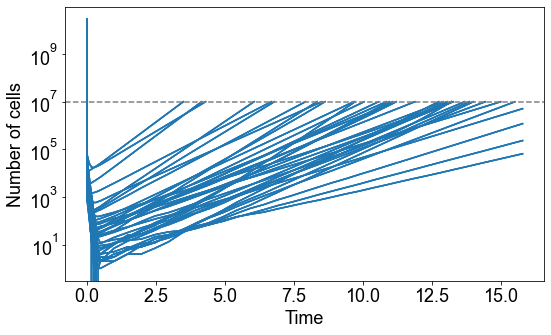

In [15]:
esim.plot_total_trajectories(scale='log',time_conversion='days_to_years',hline=10**7)

There's a lot of variability here! Let's do some survival analysis on this. The time at which the population hits the detection limit of 10^7 (if at all) is the recurrence time, or the time associated with disease progression. We will first organize the data into a table formatted for survival analysis that includes a column indicating whether the observation was right-censored (here, no recurrence yet at the 15-year post-adjuvant time point).

In [58]:
final_times=pd.DataFrame.from_dict(esim.times_final(),orient='index').rename(columns={0:'Last observation'})
final_pops=pd.DataFrame.from_dict(esim.populations_final(),orient='index').rename(columns={0:'Pop'})
patient_data=pd.concat([(final_times-0.1)/365,final_pops],1)
patient_data['Progressed']=1*(patient_data['Pop']>=10**7)
patient_data['Status']=1*((patient_data['Last observation']<=15.5) | (patient_data['Pop']>=10**7)) #Status = 1 means uncensored
patient_data=patient_data.drop('Pop',1)

In [47]:
patient_data

,Last observation,Progressed,Status
0,13.682690,1,1
1,11.186433,1,1
4,15.780822,0,0
5,11.205742,1,1
6,11.878228,1,1
7,15.780822,0,0
9,15.780822,0,0
11,15.780822,0,0
12,13.043845,1,1
13,6.055720,1,1


We will use both the Kaplan-Meier fitter and Cox proportional hazard regression modes of the Python lifelines package.

In [18]:
kmf = KaplanMeierFitter()

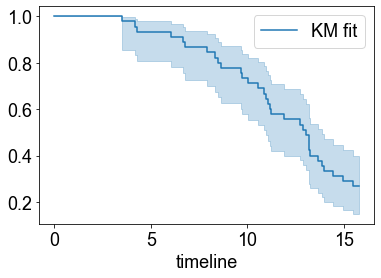

In [19]:
kmf.fit(patient_data['Last observation'],patient_data['Status'],label='KM fit').plot_survival_function()
plt.show()

In [65]:
kmf.median_survival_time_

13.043844699239633

Let's take the 10-year mark as our endpoint for patient stratification. We will define responders (R_patients) as patients who have not yet had a recurrence at 10 years post-adjuvant and non-responders (NR_patients) as those who have.

In [59]:
R_patients=list(patient_data[patient_data['Last observation']>=10].index)
NR_patients=list(patient_data[patient_data['Last observation']<10].index)

Obviously we don't have extensive clinical data in this case, but we do have the phenotype distributions, and the EnsembleSimulator modes provides tailored diversity index functionalities. We will first look at the former together with the responder/non-responder status we defined above. We are interested in the initial tumor diversity, i.e. diversity upon detection / clinical diagnosis, which we can access through the esim.diversity_at_time(0,index) functions for any of the available diversity indices (Shannon, Simpson, Gini-Simpson, Gini).

In [60]:
def diversity_table_status(index):
    R={tumor:diversity for tumor,diversity in esim.diversity_at_time(0,index).items() if tumor in R_patients}
    NR={tumor:diversity for tumor,diversity in esim.diversity_at_time(0,index).items() if tumor in NR_patients}
    R_df=pd.DataFrame.from_dict(R,orient='index').rename(columns={0:'Diversity'})
    R_df['Response status']='Responder'
    NR_df=pd.DataFrame.from_dict(NR,orient='index').rename(columns={0:'Diversity'})
    NR_df['Response status']='Non-Responder'
    df_combined=pd.concat([R_df,NR_df])
    df_combined['Index']=index
    return df_combined

In [61]:
df=pd.concat([diversity_table_status('shannon'),diversity_table_status('gini'),diversity_table_status('simpson')])

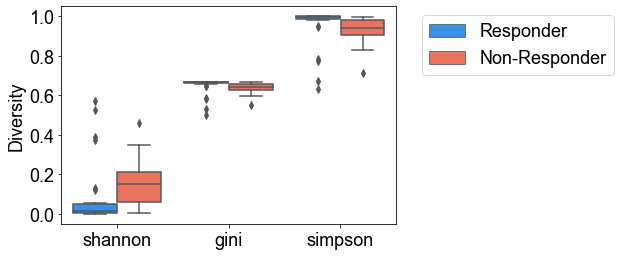

In [62]:
sns.boxplot(x='Index', y="Diversity", hue="Response status",data=df,palette=['dodgerblue','tomato'])
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.xlabel('')
plt.show()

There are clear visual distributional differences in diversity distributions between the responders and non-responders in this cohort. Let's run a couple of distributional comparison tests to confirm.

In [63]:
stats.kruskal([diversity for tumor,diversity in esim.diversity_at_time(0,'shannon').items() if tumor in R_patients],\
              [diversity for tumor,diversity in esim.diversity_at_time(0,'shannon').items() if tumor in NR_patients])

KruskalResult(statistic=9.172595520421623, pvalue=0.002456659134508952)

In [64]:
stats.mannwhitneyu([diversity for tumor,diversity in esim.diversity_at_time(0,'shannon').items() if tumor in R_patients],\
              [diversity for tumor,diversity in esim.diversity_at_time(0,'shannon').items() if tumor in NR_patients])

MannwhitneyuResult(statistic=80.0, pvalue=0.0012815275936283337)